In [10]:
import numpy as np
from mindquantum.core.gates import RX, RY, RZ, H, X, Y, Z, CNOT
from mindquantum.core.circuit import Circuit
import mindspore as ms
from mindquantum.simulator import  Simulator
from mindquantum.core.gates import GroupedPauli
from mindquantum.core.operators import TimeEvolution,QubitOperator
from mindquantum.core.parameterresolver import PRConvertible,PRGenerator,ParameterResolver
from DQAS_tool import generate_pauli_string,one_hot,unbound_opeartor_pool
from mindquantum.core.gates import RotPauliString
from mindquantum.core.gates import UnivMathGate
from mindspore import Tensor, ops
from mindquantum.core.circuit import UN
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量
from mindquantum.framework import MQLayer,MQOps
from mindspore.nn import  TrainOneStepCell
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam                                                  # 导入Adam模块用于定义优化参数
from mindspore.train import Accuracy, Model, LossMonitor                       # 导入Accuracy模块，用于评估预测准确率
import mindspore as ms
from mindspore import Parameter, Tensor
from mindspore.dataset import NumpySlicesDataset
from torch.utils.data import DataLoader# 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集
import sys
sys.path.append('..')
from data_processing import X_train,X_test,y_train,y_test
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz     
# #Operator Pool


In [11]:
unbound_opeartor_pool = \
["X0 X1 I2 I3 I4 I5 I6 I7", 
 "I0 X1 X2 I3 I4 I5 I6 I7",
 "I0 I1 X2 X3 I4 I5 I6 I7",
 "I0 I1 I2 X3 X4 I5 I6 I7",
 "I0 I1 I2 I3 X4 X5 I6 I7",
 "I0 I1 I2 I3 I4 I4 X6 I7",
 "Y0 Y1 I2 I3 I4 I4 I6 I7",
 "I0 Y1 Y2 I3 I4 I4 I6 I7",
 "I0 I1 Y2 Y3 I4 I4 I6 I7",
 "I0 I1 I2 Y3 Y4 I4 I6 I7",
 "I0 I1 I2 I3 Y4 Y5 I6 I7",
 "I0 I1 I2 I3 I4 Y5 Y6 I7",
 ]
bound_opeartor_pool = \
['ZYIXXXZX',
 'IZZYYXZI',
 'XIIXYIIZ',
 'IIIYYIYX',
 'IZZYIXZI',
 'ZZYYYYYY']

num_layer = 7
# 定义标准差和形状
stddev = 0.02
shape_parametized = len(unbound_opeartor_pool)
shape_unparametized = len(bound_opeartor_pool)
shape_nnp = (num_layer, shape_parametized)
shape_stp = (num_layer, shape_parametized+shape_unparametized)

nnp = np.random.normal(loc=0.0, scale=stddev, size=shape_nnp)
stp = np.random.normal(loc=0.0, scale=stddev, size=shape_stp)

np.random.seed(10)
unbound_opeartor_pool = [generate_pauli_string(n=8,seed=i)[0] for i in range(shape_parametized)]
bound_opeartor_pool = [generate_pauli_string(n=8,seed=i)[1] for i in range(shape_parametized,shape_parametized+shape_unparametized)]

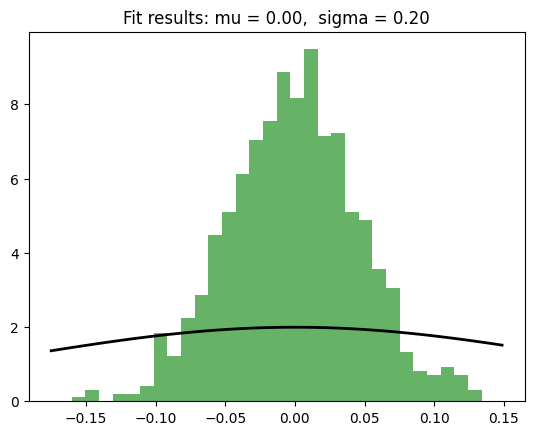

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 生成正态分布的随机数
shape_nnp = (1000,)  # 生成 1000 个随机数
rtype = np.float32
random_array = np.random.normal(loc=0.0, scale=0.05, size=shape_nnp).astype(rtype)

# 绘制直方图
plt.hist(random_array, bins=30, density=True, alpha=0.6, color='g')

# 绘制正态分布的概率密度函数
mu, sigma = 0.0, 0.2
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  sigma = %.2f" % (mu, sigma)
plt.title(title)

plt.show()

In [13]:
from DQAS_tool import Mindspore_ansatz,sampling_from_structure


In [16]:
def Mindspore_ansatz(Structure_p:np.array,
                     parameterized_pool:list,
                     unparameterized_pool:list,
                     num_layer:int=6,
                     n_qbits:int=8):
    """
    和 DQAS 文章描述的一致，生成权重线路
    Structure_p:np.array DQAS中的权重参数,
    Ansatz_p:np.array  DQAS中的Ansatz参数,
    
    """
    if Structure_p.shape[0] != num_layer:
        raise ValueError('Structure_p shape must be equal to num_layer')
    
    if Structure_p.shape[1] != len(unbound_opeartor_pool)+len(bound_opeartor_pool):
        raise ValueError('Structure_p shape must be equal to size of pool')
    softmax = ops.Softmax()
    my_stp = softmax(Tensor(Structure_p, ms.float32))
    
    prg = PRGenerator('encoder')
    nqbits = n_qbits
    encoder = Circuit()
    encoder += UN(H, nqbits)                                 
    for i in range(nqbits):                                  
        encoder += RY(prg.new()).on(i)                 
        
    ansatz = Circuit()
    pr_gen = PRGenerator('ansatz')
    #print(my_stp.shape)
    for i in range(num_layer):
        paramertized_part_count=0
        for index_op,each_op in enumerate(parameterized_pool):
            #print(my_stp[i,index_op])
            ansatz += TimeEvolution(QubitOperator(terms=each_op,coefficient=pr_gen.new()),time=float(my_stp[i,index_op])).circuit
            paramertized_part_count+=1
            
        for index_op,each_op in enumerate(unparameterized_pool):
            op = GroupedPauli(each_op)
            tmp_cir = Circuit([GroupedPauli(each_op).on(range(n_qbits))])
            matrix = tmp_cir.matrix()
            ansatz += UnivMathGate(matrix_value=matrix*float(my_stp[i,index_op+paramertized_part_count]),name=f'{my_stp[i,index_op+paramertized_part_count]}*{op.pauli_string}').on(range(n_qbits))  
    
    finnal_ansatz = encoder.as_encoder() + ansatz.as_ansatz()
    return finnal_ansatz

In [17]:
ansatz = Mindspore_ansatz(Structure_p=stp,parameterized_pool=unbound_opeartor_pool,unparameterized_pool=bound_opeartor_pool,num_layer=num_layer,n_qbits=8)

In [19]:
from DQAS_tool import loss_fn
def vag_nnp2(Structure_params: np.array, Ansatz_params: np.array,paramerterized_pool:list,unparamterized_pool:list,num_layer:int=6,n_qbits:int=8):
    """
    用于计算梯度 Ansatz_params关于 loss 的梯度
    value,grad_ansatz_params = vag(训练数据,标签数据)
    """
    ansatz = Mindspore_ansatz(Structure_p=Structure_params,
                              parameterized_pool=paramerterized_pool,unparameterized_pool=unparamterized_pool,
                              num_layer=num_layer,n_qbits=n_qbits)
    sim = Simulator(backend='mqvector', n_qubits=n_qbits)
    hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [0, 1]]
    grad_ops = sim.get_expectation_with_grad(hams, ansatz)
    #print(Ansatz_params.shape)
    Mylayer = MQLayer(grad_ops,ms.Tensor(Ansatz_params,ms.float64).reshape(-1))


    def forward_fn(encode_p,y_label):
        eval_obserables = Mylayer(encode_p)
        loss = loss_fn(eval_obserables, y_label)
        return loss
    # nnp = ms.Tensor(Ansatz_params).reshape(-1)
    grad_fn = ms.value_and_grad(fn=forward_fn,grad_position=None,weights=Mylayer.trainable_params())
    
    return grad_fn

In [ ]:
import numpy as np
import tensorcircuit as tc
import tensorflow as tf
from DQAS_tool import  DQASAnsatz_from_result,vag_nnp,nmf_gradient
K = tc.set_backend("tensorflow")
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.06, 100, 0.5)
structure_opt = tc.backend.optimizer(tf.keras.optimizers.Adam(0.05))
network_opt = tc.backend.optimizer(tf.keras.optimizers.Adam(lr))
verbose = False
# 设置超参数
epochs = 100
batch_size=256
# shape_nnp = (num_layer, shape_parametized)
# shape_stp = (num_layer, shape_parametized+7)
# nnp = np.random.normal(loc=0.0, scale=stddev, size=shape_nnp).astype(rtype)
# stp = np.random.normal(loc=0.0, scale=stddev, size=shape_stp).astype(rtype)
print('sdsd',stp.shape)
avcost1 = 0

ops_onehot = ops.OneHot(axis=-1)

avcost2 = avcost1

costl = []
tmp = np.stack([sampling_from_structure(stp,num_layer,shape_parametized) for _ in range(batch_size)])
batch_structure = ops_onehot(ms.Tensor(tmp),shape_parametized+shape_unparametized,ms.Tensor(1),ms.Tensor(0))
#print(batch_structure.shape)
# print(tmp,batch_structure)
loss_value = []
grad_nnps = []
grad_stps = []
    
for i in batch_structure:          
    infd, grad_nnp = vag_nnp2(Structure_params=i,Ansatz_params=nnp,paramerterized_pool=unbound_opeartor_pool,unparamterized_pool=bound_opeartor_pool,num_layer=num_layer,n_qbits=8)(ms.Tensor(X_train),ms.Tensor(y_train))
    gs = nmf_gradient(structures=stp,oh=i,num_layer=num_layer,size_pool=shape_parametized+shape_unparametized)
    #print(infd,grad_nnp)
    loss_value.append(infd)
    grad_nnps.append(grad_nnp[0])
    grad_stps.append(gs)

infd = ops.stack(loss_value)
gnnp = ops.addn(grad_nnps)
gstp = [(infd[i] - avcost2) * grad_stps[i] for i in range(infd.shape[0])]
gstp_averge = ops.addn(gstp) / infd.shape[0]
avcost1 = sum(infd) / infd.shape[0]

    
print(gstp_averge)
 

sdsd (7, 18)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1051fa6a0>>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
